This script calibrates BEACO2N carbon monoxide data using QuantAQ sensors as reference. The script only applies this calibration to colocated sites, i.e. Department of Public Works, Providence Emergency Management Agency, and Providence Housing Authority. 

In [26]:
import os
from glob import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Clean and pre-process raw data.

In [27]:
# Parse the measurement and reference dataframe lists from csv files in project folder.
measurement_files = glob("./BEACO2N_measurements/*.csv")
measurement_df = {os.path.splitext(os.path.basename(f))[0] : pd.read_csv(f) for f in measurement_files}
reference_files = glob("./reference_measurements/*.csv")
reference_df = {os.path.splitext(os.path.basename(f))[0] : pd.read_csv(f) for f in reference_files}

# Clean measurement and reference data.

def clean_measurement(df: pd.DataFrame) -> pd.DataFrame :
    # Store time in Pandas datetime format.
    df = df.rename(columns={"datetime":"timestamp", "co2_raw":"co2"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.round("h")

    # Drop redundant time columns
    df = df.drop(columns=[col for col in ["local_timestamp", "epoch", "node_file_id", "node_id"] if col in df.columns])
    
    # For all columns suffixed by "_wrk_aux", convert from Volts to milliVolts (*1000) and remove suffix
    wrk_aux_cols = df.filter(regex=r"_wrk_aux$").columns
    df[wrk_aux_cols] *= 1000
    df.rename(columns= {col : col.replace("_wrk_aux", "") for col in wrk_aux_cols}, inplace=True)
    
    # Drop all datapoints with incomplete data (e.g. missing co measurement)
    df = df.dropna()
    return df

# Clean each site's dataframe
measurement_df = {site: clean_measurement(df) for site, df in measurement_df.items()}

# Clean data for reference (QuantAQ) analogously
def clean_reference(df: pd.DataFrame) -> pd.DataFrame :
    df = df.drop(columns=[col for col in ["period_start", "period_end", "period_end_utc", "sn"] if col in df.columns])
    df = df.rename(columns={"period_start_utc": "timestamp", "pm25": "pm2_5"})
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df = df.dropna()
    return df

reference_df = {key: clean_reference(df) for key, df in reference_df.items()}

In [28]:
# Remove CO outliers from every site's data, including reference. 
def rm_outliers(df : pd.DataFrame) -> pd.DataFrame :
    co_zscore = abs(df['co']-df['co'].mean())/df['co'].std()
    df = df[co_zscore < 3]
    return df

measurement_df = {site: rm_outliers(df) for site, df in measurement_df.items()}
reference_df = {key: rm_outliers(df) for key, df in reference_df.items()}

### Distributed Calibration:
Find time intervals when RSD(co) < 0.10 for all reference sensors in the network:

In [29]:
from functools import reduce
rsd_df = []

# Add each site's timestamp and co data to a list of co tables with site column headers.
[rsd_df.append(df[["timestamp","co"]].rename(columns={'co':site})) for site, df in reference_df.items()]
# Merge the co tables into one table. 
rsd_df = reduce(lambda table, to_merge: pd.merge(table, to_merge, on="timestamp", how="inner"), rsd_df) # type: ignore

def rsd(row:pd.Series) -> float:
    ''' Helper function to calculate residual standard deviation of a dataframe row. '''
    vals = row[1:].values.astype(float)
    mean = np.mean(vals)
    sd = np.std(vals)
    return float(sd/mean) if mean != 0 else np.nan

rsd_df["rsd"]=rsd_df.apply(rsd, axis=1)
timestamps_rsd_lt_10pc = rsd_df[rsd_df["rsd"]<.10]["timestamp"]
timestamps_rsd_gt_10pc = rsd_df[rsd_df["rsd"]>.10]["timestamp"]

# Filter datasets to include only data contained by 
# intersection(timestamps_rsd_lt_10pc, measurement[site]["timestamp"], reference["timestamp"])

ref_times_rsd_lt_10pc = timestamps_rsd_lt_10pc
'''A list of timestamps contained in all of: timestamps_rsd_lt_10pc, dpw, pema, pha'''
for ref_site in reference_df: ref_times_rsd_lt_10pc = ref_times_rsd_lt_10pc[ref_times_rsd_lt_10pc.isin(reference_df[ref_site]["timestamp"])]

meas_times_rsd_lt_10pc = {}
'''A map from measurement sites to list of timestamps containing ⋂(ref_times_rsd_lt_10pc, meas_site["timestamps"])'''
for meas_site in measurement_df.keys(): meas_times_rsd_lt_10pc[meas_site] = ref_times_rsd_lt_10pc[ref_times_rsd_lt_10pc.isin(measurement_df[meas_site]["timestamp"])]

ref_times_rsd_gt_10pc = timestamps_rsd_gt_10pc
'''A list of timestamps contained in all of: timestamps_rsd_gt_10pc, dpw, pema, pha'''
for ref_site in reference_df: ref_times_rsd_gt_10pc = ref_times_rsd_gt_10pc[ref_times_rsd_gt_10pc.isin(reference_df[ref_site]["timestamp"])]

meas_times_rsd_gt_10pc = {}
'''A map from measurement sites to list of timestamps containing ⋂(ref_times_rsd_gt_10pc, meas_site["timestamps"])'''
for meas_site in measurement_df.keys(): meas_times_rsd_gt_10pc[meas_site] = ref_times_rsd_gt_10pc[ref_times_rsd_gt_10pc.isin(measurement_df[meas_site]["timestamp"])]



Assign each measurement (BEACO2N) sensor to a reference sensor and train a calibration model (for each measurement sensor) using timestamps with RSC(co)<0.10 within the reference network.

Note: Measurement nodes are assigned to the nearest reference node according to calculations done in QGIS with Grace's BPP network map. May be worth confirming this using ArcGIS at some point. (Perhaps RIDEM data can eventually be used to improve spacial accuracy... some nodes are >2mi from reference.)

| Reference | Measurement locations |
|------------|-------------------------|
| dpw | reservoir, medschool, dpw, ccri, southprovlib, prek, gym, cfs, myron|
| pema | ecubed, rochambeau, smithhill, martialarts, blackstone, rocklib, provcollege, pema|
| pha | silverlake, carnevale, zuccolo, wecc, unitedway, pha, mtpleasant, ricollege|


Fit per-site regression models to the data where RSC(co)<0.10:

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

zones = {
    "dpw" : ["reservoir", "medschool", "dpw", "ccri", "southprovlib", "prek", "gym", "cfs", "myron"],
    "pema" : ["ecubed", "rochambeau", "smithhill", "martialarts", "blackstone", "rocklib", "provcollege", "pema"],
    "pha" : ["silverlake", "carnevale", "zuccolo", "wecc", "unitedway", "pha", "mtpleasant", "ricollege"]
}

models = {ref_site : {meas_site : LinearRegression() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
X_train = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
X_test = {ref_site : {meas_site : pd.DataFrame() for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_train = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}
y_test_pred = {ref_site : {meas_site : pd.Series(dtype=float) for meas_site in zones[ref_site]} for ref_site in zones.keys()}

for ref_site in zones.keys():
    for meas_site in zones[ref_site]:
        # Get the indices for train/test split based on the available timestamps for this measurement site
        train_indxs, test_indxs = train_test_split(range(len(meas_times_rsd_lt_10pc[meas_site])), random_state=0)
        
        # Select the timestamps for train/test
        train_times = meas_times_rsd_lt_10pc[meas_site].iloc[train_indxs]
        test_times = meas_times_rsd_lt_10pc[meas_site].iloc[test_indxs]
        
        drop_cols = ["timestamp", "co_corrected"]

        # Select the measurement data for train/test, dropping timestamp column
        X_train[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(train_times)].drop(columns=drop_cols)
        X_test[ref_site][meas_site] = measurement_df[meas_site][measurement_df[meas_site]["timestamp"].isin(test_times)].drop(columns=drop_cols)

        X_train[ref_site][meas_site] = X_train[ref_site][meas_site][["co", "temp", "rh"]]
        X_test[ref_site][meas_site] = X_test[ref_site][meas_site][["co", "temp", "rh"]]

        # Select the reference data for train/test, matching timestamps
        y_train[ref_site][meas_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(train_times)]["co"]
        y_test[ref_site][meas_site] = reference_df[ref_site][reference_df[ref_site]["timestamp"].isin(test_times)]["co"]
        
        models[ref_site][meas_site].fit(X_train[ref_site][meas_site], y_train[ref_site][meas_site])
        y_test_pred[ref_site][meas_site] = models[ref_site][meas_site].predict(X_test[ref_site][meas_site]) # type: ignore

Display residual graphs and statistics for each site model. 

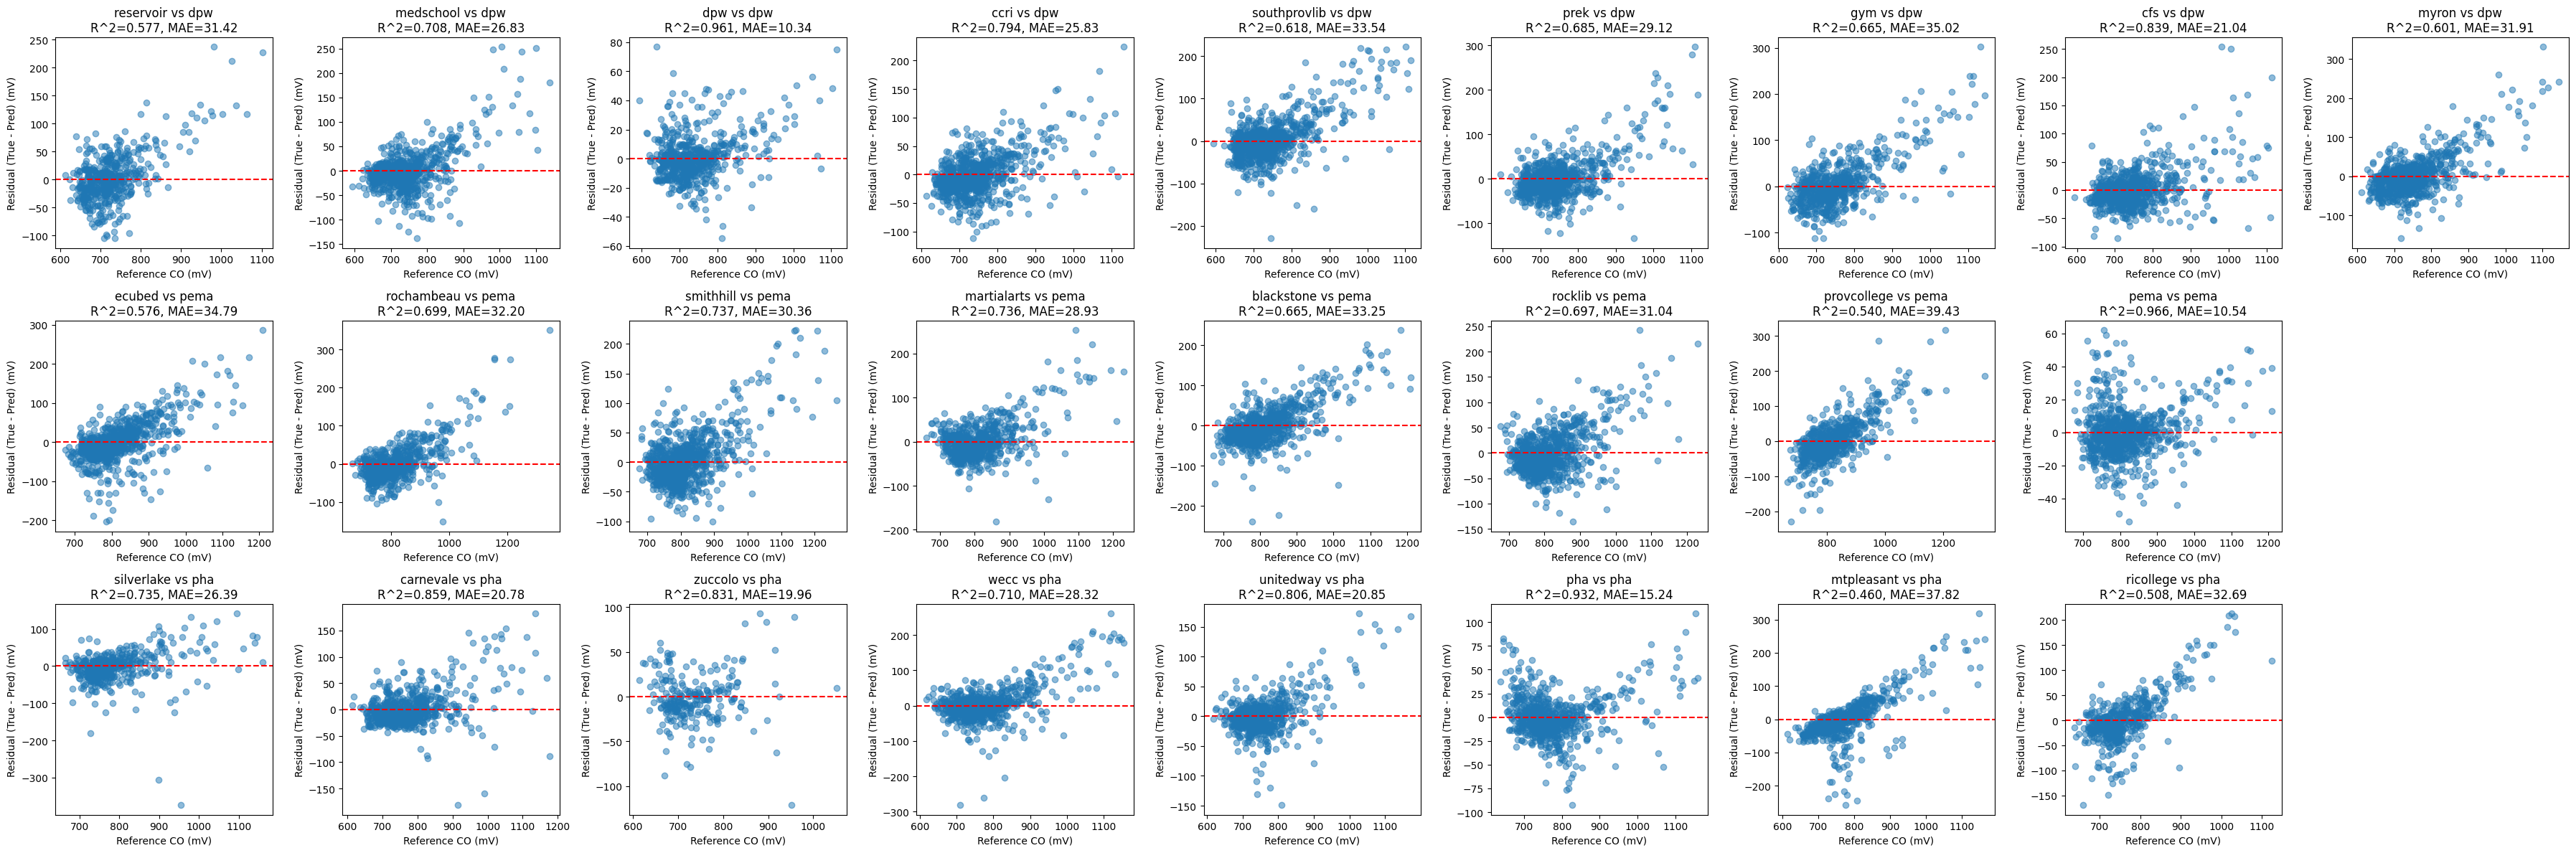

,Reference,Measurement,Determination R^2,Correlation r,RMSE,MAE,Intercept,co_coef,temp_coef,rh_coef
0,dpw,reservoir,0.5771,0.7624,43.7451,31.4201,765.0570,1.5351,-3.8224,-1.2340
1,dpw,medschool,0.7076,0.8413,41.6044,26.8321,718.1163,1.3197,-3.7677,-1.1552
2,dpw,dpw,0.9606,0.9803,15.0455,10.3414,703.8697,1.8908,-3.0897,-1.1926
3,dpw,ccri,0.7940,0.8915,35.4106,25.8333,678.9026,1.9015,-3.9307,-1.3860
4,dpw,southprovlib,0.6182,0.7871,49.5370,33.5378,749.8319,1.4597,-4.1296,-1.5632
5,dpw,prek,0.6855,0.8282,43.7446,29.1162,624.6996,2.1359,-4.1745,-1.5508
6,dpw,gym,0.6650,0.8232,50.9732,35.0231,710.5377,1.3990,-4.3003,-1.3057
7,dpw,cfs,0.8388,0.9161,32.1861,21.0419,716.1315,1.8897,-3.1480,-0.9713
8,dpw,myron,0.6013,0.7759,47.8664,31.9134,702.0971,1.3098,-3.4603,-0.5979
9,pema,ecubed,0.5762,0.7597,49.5369,34.7940,792.3049,1.2490,-3.5877,-1.0721


In [31]:
import matplotlib.pyplot as plt
from numpy import sqrt
from sklearn.metrics import mean_absolute_error, r2_score

def plot_zones(zones:dict, y_test, y_test_pred) :

    num_refsites = len(zones)
    max_num_meassites = max(len(sites) for sites in zones.values())

    fig, axes = plt.subplots(num_refsites, max_num_meassites, figsize=(4*max_num_meassites, 4*num_refsites), squeeze=False)

    statistics = []

    for row, (ref_site, meas_site_list) in enumerate(zones.items()):
        for col, meas_site in enumerate(meas_site_list):
            y_true = y_test[ref_site][meas_site]
            y_pred = y_test_pred[ref_site][meas_site]
            if len(y_true)==0 or len(y_pred)==0:
                axes[row][col].set_visible(False); continue
            residual = y_true - y_pred
            axes[row, col].scatter(y_true, residual, alpha=0.5)
            axes[row, col].axhline(0, color='red', linestyle='--')
            axes[row, col].set_title(f"{meas_site} vs {ref_site}\nR^2={r2_score(y_true, y_pred):.3f}, MAE={mean_absolute_error(y_true, y_pred):.2f}")
            axes[row, col].set_xlabel("Reference CO (mV)")
            axes[row, col].set_ylabel("Residual (True - Pred) (mV)")
            for unused_col in range(len(meas_site_list), max_num_meassites): axes[row, unused_col].set_visible(False)

            model = models[ref_site][meas_site]
            statistics.append({
                "Reference" : ref_site,
                "Measurement" : meas_site,
                "Determination R^2" : r2_score(y_true, y_pred),
                "Correlation r" : np.corrcoef(y_true, y_pred)[0,1], 
                "RMSE" : sqrt(np.mean((y_true-y_pred)**2)), 
                "MAE" : mean_absolute_error(y_true, y_pred), 
                "Intercept" : model.intercept_,
                "co_coef" : model.coef_[0],
                "temp_coef" : model.coef_[1],
                "rh_coef" : model.coef_[2] 
            })
    
    statistics.append({
        "Reference" : 'Mean', 
        'Measurement': '', 
        'Determination R^2' : np.mean([val.get("Determination R^2") for val in statistics]), 
        'Correlation r' : np.mean([val.get("Correlation r") for val in statistics]), 
        'RMSE' : np.mean([val.get('RMSE') for val in statistics]), 
        'MAE' : np.mean([val.get('MAE') for val in statistics]), 
        'Intercept' : np.mean([val.get('Intercept') for val in statistics]), 
        'co_coef' : np.mean([val.get('co_coef') for val in statistics]), 
        'temp_coef' : np.mean([val.get('temp_coef') for val in statistics]), 
        'rh_coef' : np.mean([val.get('rh_coef') for val in statistics]) 
    })
    plt.tight_layout(); plt.show()
    display(pd.DataFrame(statistics).round(4))

plot_zones(zones, y_test, y_test_pred)


Test the trained models on timestamps outsite of the RSD(co)<0.10 set. 